In [1]:
import os
import numpy as np
import scanpy as sc
import anndata as ad
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
plt.rcParams['figure.figsize']=(5, 5)
plt.rcParams['figure.dpi'] = 100
sc.settings.verbosity = 3
sc.logging.print_versions()

%load_ext autoreload
%autoreload 2 

scanpy==1.4.4.post1 anndata==0.7.4 umap==0.3.10 numpy==1.19.2 scipy==1.5.2 pandas==1.1.2 scikit-learn==0.23.2 statsmodels==0.12.0 python-igraph==0.8.2 louvain==0.6.1


In [2]:
import rpy2.rinterface_lib.callbacks
import logging
import warnings
from rpy2.robjects import pandas2ri
import anndata2ri


# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

In [4]:
%%R
library(MAST)
sessionInfo()

R version 3.6.2 (2019-12-12)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Debian GNU/Linux 10 (buster)

Matrix products: default
BLAS:   /app/R36/lib/R/lib/libRblas.so
LAPACK: /app/R36/lib/R/lib/libRlapack.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] parallel  stats4    tools     stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] MAST_1.12.0                 SingleCellExperiment_1.8.0 
 [3] SummarizedExperiment_1.16.1 DelayedArray_0.12.3        
 [5] BiocParallel_1.20.1         matrixStats_0.56.0         
 [7] Biobase_2.46.0              GenomicRanges_1.38.0       
 [9] GenomeInf

# Dataloading

In [10]:
adatas = []

data_file = './../../data/raw/CLT_A1/raw_gene_bc_matrices/mm10/matrix.mtx'
barcode_file = './../../data/raw/CLT_A1/raw_gene_bc_matrices/mm10/barcodes.tsv'
gene_file = './../../data/raw/CLT_A1/raw_gene_bc_matrices/mm10/genes.tsv'

adata = sc.read(data_file, cache=True)
adata = adata.transpose()

barcodes = pd.read_csv(barcode_file, header=None, sep='\t')
genes = pd.read_csv(gene_file, header=None, sep='\t')

#Annotate data
barcodes.rename(columns={0:'barcode'}, inplace=True)
barcodes.set_index('barcode', inplace=True)
adata.obs = barcodes
adata.obs['tissue'] = 'Adrenal'
adata.obs['condition'] = 'Control'
genes.rename(columns={0:'gene_id', 1:'gene_symbol'}, inplace=True)
genes.set_index('gene_symbol', inplace=True)
adata.var = genes
adata.var_names_make_unique()
adatas.append(adata)

##############################################################################################
data_file = './../../data/raw/CSD_A1/raw_gene_bc_matrices/mm10/matrix.mtx'
barcode_file ='./../../data/raw/CSD_A1/raw_gene_bc_matrices/mm10/barcodes.tsv'
gene_file ='./../../data/raw/CSD_A1/raw_gene_bc_matrices/mm10/genes.tsv'

adata = sc.read(data_file, cache=True)
adata = adata.transpose()

barcodes = pd.read_csv(barcode_file, header=None, sep='\t')
genes = pd.read_csv(gene_file, header=None, sep='\t')

#Annotate data
barcodes.rename(columns={0:'barcode'}, inplace=True)
barcodes.set_index('barcode', inplace=True)
adata.obs = barcodes
adata.obs['tissue'] = 'Adrenal'
adata.obs['condition'] = 'Stress'
genes.rename(columns={0:'gene_id', 1:'gene_symbol'}, inplace=True)
genes.set_index('gene_symbol', inplace=True)
adata.var = genes
adatas.append(adata)
adata.var_names_make_unique()
adata = adatas[0].concatenate(adatas[1:])
print(adata)

del adatas

... reading from cache file cache/..-..-data-raw-CLT_A1-raw_gene_bc_matrices-mm10-matrix.h5ad
... writing an h5ad cache file to speedup reading next time
AnnData object with n_obs × n_vars = 1474560 × 27998
    obs: 'tissue', 'condition', 'batch'
    var: 'gene_id'


In [11]:
print(adata.obs['condition'].value_counts())
print('')

Stress     737280
Control    737280
Name: condition, dtype: int64



# QC

In [12]:
# Quality control - calculate QC covariates
adata.obs['n_counts'] = adata.X.sum(1)
adata.obs['log_counts'] = np.log(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X > 0).sum(1)

/app/python37/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


/app/python37/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


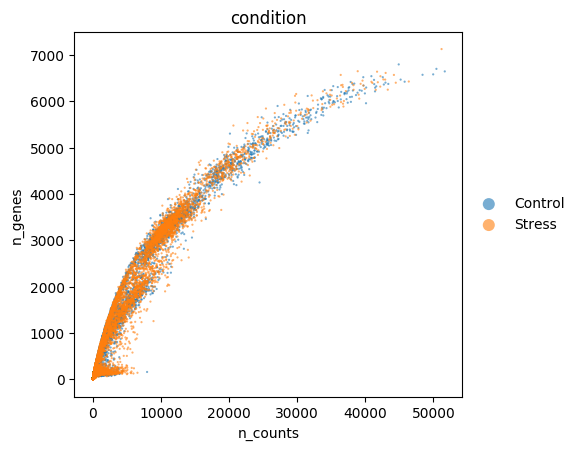

In [14]:
#Data quality summary plots
plt.rcParams['figure.figsize'] = (5, 5)
p1 = sc.pl.scatter(adata, 'n_counts', 'n_genes', size=10, color='condition', alpha=0.6)

/app/python37/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/app/python37/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


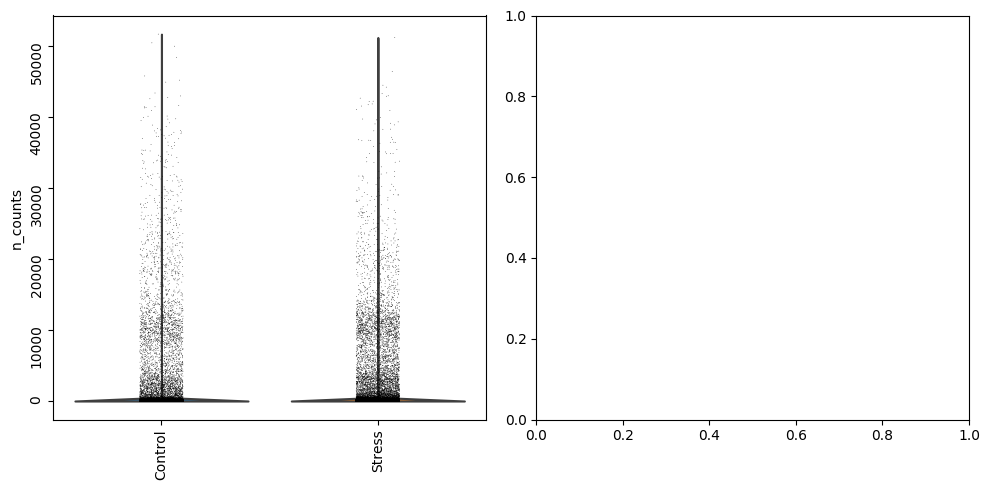

In [16]:
# Quality control - plot QC metrics
#Sample quality plots
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
t1 = sc.pl.violin(adata, 'n_counts', groupby='condition', size=0.5, log=False, cut=0, rotation=90, show=False, ax=ax[0])
fig.tight_layout()

/app/python37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/app/python37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/app/python37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level 

Text(0.5, 0.98, 'Count distribution')

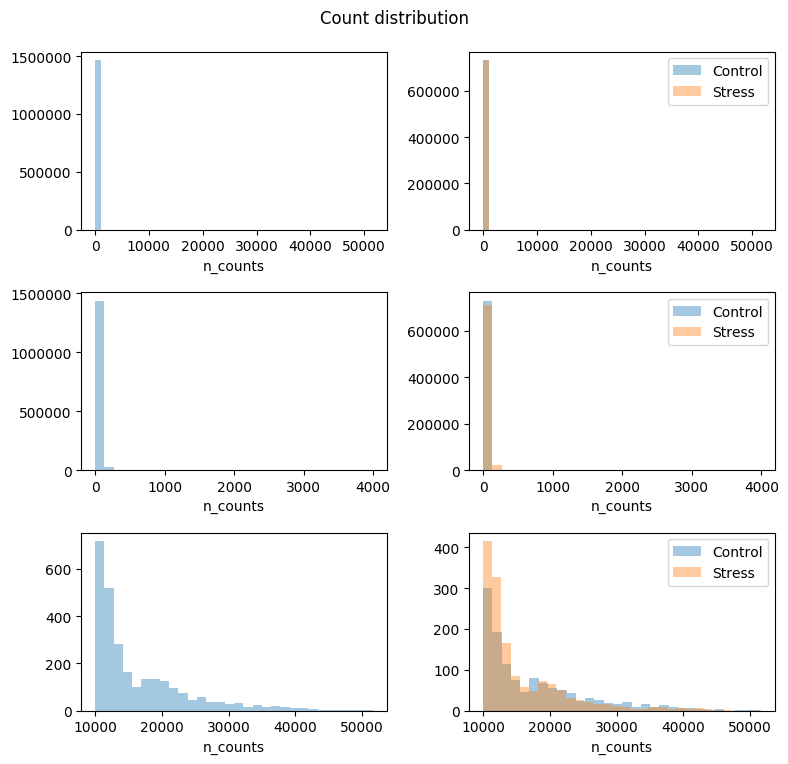

In [17]:
#Thresholding decision: counts
fig, ax = plt.subplots(3, 2, figsize=(8, 8))
sns.distplot(adata.obs['n_counts'], kde=False, ax=ax[0, 0])
sns.distplot(adata.obs['n_counts'][adata.obs['condition']=='Control'], kde=False, ax=ax[0, 1])
sns.distplot(adata.obs['n_counts'][adata.obs['condition']=='Stress'], kde=False, ax=ax[0, 1])
ax[0, 1].legend(['Control', 'Stress'])

sns.distplot(adata.obs['n_counts'][adata.obs['n_counts']<4000], kde=False, bins=30, ax=ax[1, 0])
sns.distplot(adata.obs['n_counts'][adata.obs['condition']=='Control'][adata.obs['n_counts']<4000], kde=False, bins=30, ax=ax[1, 1])
sns.distplot(adata.obs['n_counts'][adata.obs['condition']=='Stress'][adata.obs['n_counts']<4000], kde=False, bins=30, ax=ax[1, 1])
ax[1, 1].legend(['Control', 'Stress'])

sns.distplot(adata.obs['n_counts'][adata.obs['n_counts']>10000], kde=False, bins=30, ax=ax[2, 0])
sns.distplot(adata.obs['n_counts'][adata.obs['condition']=='Control'][adata.obs['n_counts']>10000], kde=False, bins=30, ax=ax[2, 1])
sns.distplot(adata.obs['n_counts'][adata.obs['condition']=='Stress'][adata.obs['n_counts']>10000], kde=False, bins=30, ax=ax[2, 1])
ax[2, 1].legend(['Control', 'Stress'])

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle('Count distribution')

/app/python37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/app/python37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/app/python37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level 

Text(0.5, 0.98, 'Gene distribution')

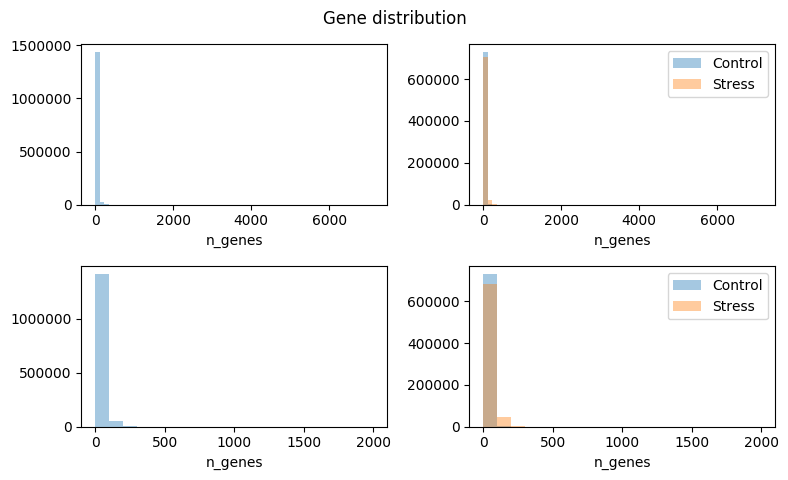

In [18]:
# Thresholding decision: genes
fig, ax = plt.subplots(2, 2, figsize=(8, 5))
sns.distplot(adata.obs['n_genes'], kde=False, bins=60, ax=ax[0, 0])
sns.distplot(adata.obs['n_genes'][adata.obs['condition']=='Control'], kde=False, bins=60, ax=ax[0, 1])
sns.distplot(adata.obs['n_genes'][adata.obs['condition']=='Stress'], kde=False, bins=60, ax=ax[0, 1])
ax[0, 1].legend(['Control', 'Stress'])

sns.distplot(adata.obs['n_genes'][adata.obs['n_genes']<2000], kde=False, bins=20, ax=ax[1, 0])
sns.distplot(adata.obs['n_genes'][adata.obs['condition']=='Control'][adata.obs['n_genes']<2000], kde=False, bins=20, ax=ax[1, 1])
sns.distplot(adata.obs['n_genes'][adata.obs['condition']=='Stress'][adata.obs['n_genes']<2000], kde=False, bins=20, ax=ax[1, 1])
ax[1, 1].legend(['Control', 'Stress'])

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle('Gene distribution')

In [19]:
# Filter cells according to identified QC thresholds:
print('Total number of cells: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, max_counts = 200)
print('Number of cells after min count filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_counts = 50)
print('Number of cells after min count filter: {:d}'.format(adata.n_obs))

Total number of cells: 1474560
filtered out 13713 cells that havemore than 200 counts


/app/python37/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


Number of cells after min count filter: 1460847
filtered out 1353149 cells that haveless than 50 counts
Number of cells after min count filter: 107698


In [20]:
print('Total number of genes: {:d}'.format(adata.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=20)
print('Number of genes after cell filter: {:d}'.format(adata.n_vars))

Total number of genes: 27998
filtered out 16314 genes that are detectedin less than 20 cells
Number of genes after cell filter: 11684


/app/python37/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


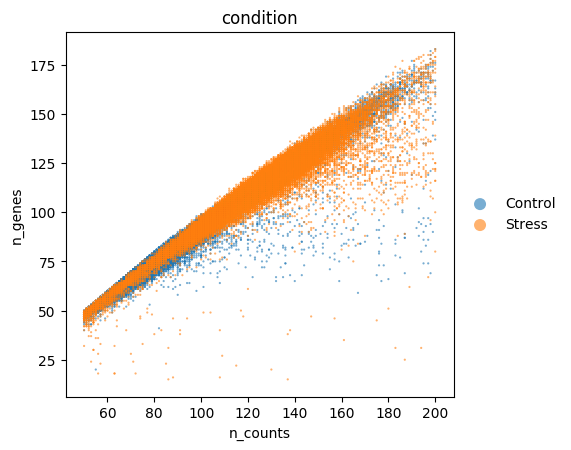

In [21]:
#Data quality summary plots
p1 = sc.pl.scatter(adata, 'n_counts', 'n_genes', size=10, color='condition', alpha=0.6)
#p2 = sc.pl.scatter(adata[adata.obs['n_counts']<10000], 'n_counts', 'n_genes', color='mt_frac', size=10, alpha=0.6)

In [22]:
sc.pp.normalize_total(adata)

Normalizing counts per cell.
    finished (0:00:00):normalized adata.X


In [23]:
sc.pp.normalize_per_cell(adata)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [24]:
sc.pp.log1p(adata)

/app/python37/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:284: DeprecationWarning: Use is_view instead of isview, isview will be removed in the future.
  if isinstance(data, AnnData) and data.isview:


In [25]:
adata.raw = adata

/app/python37/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [26]:
sc.pp.highly_variable_genes(adata, flavor='cell_ranger', n_top_genes=2000, subset=True)
print('\n','Number of highly variable genes: {:d}'.format(np.sum(adata.var['highly_variable'])))

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)

 Number of highly variable genes: 2000


/app/python37/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [19]:
import sys
sys.path.append('./../../code/') 
from mast_scripts import mast_de_bulk

In [21]:
de_bulk = mast_de_bulk(adata, save='./results/de_adrenal_ambient_.xlsx')

(2000,)
[1] "Deploying to R..."
[1] "Begin computation..."
